# Model 2 testing

## Introduction

This file will serve solely to try out the performance of different models in orther to choose which one is the best for the data (model 2).

Creating this file will help with keeping track of the results and the advancements of the proyect.

## Index of models tried

1. Logistic Regression (variable importance analysis)
2. SVR
3. Bagging (R)
4. Random Forest (R)
5. Boosting (Gradient, Cat, XGB, Light)
6. Stacks
7. Linear Regression (with clustering and my variant)
8. Pipelines with reduction of dimensionality

In [2]:
# Load the necessary modules
# Relative paths (make sure you are in src)
import os, sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# Data management libraries 
import numpy as np 
import pandas as pd 
import math
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# My code
from data_processing import get_path
from Models.RandomForest import Random_Forest_ensemble
from Models.BaggingEnsemble import Bagging_Ensemble
from Models.LinearRegressor import LinearRegressor
from Models.LogisticRegressor import LogisticRegressor
from Models.LinearRegressionVariants import LR_Relations, LR_ensemble
from Models.SVR import SVR_manual
from Models.Boosting import Boosting_Regressor
from utils import evaluate_classification_metrics, evaluate_regression_metrics, cross_validation, plot_residuals_color
from data_processing import standarize_numerical_variables

# Machine learning libraries 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import BaggingClassifier, BaggingRegressor, RandomForestClassifier, RandomForestRegressor,StackingRegressor,StackingClassifier,GradientBoostingRegressor
from sklearn.metrics import accuracy_score, mean_absolute_error,mean_squared_error,confusion_matrix, make_scorer,  silhouette_score, davies_bouldin_score
from sklearn.tree import DecisionTreeRegressor, export_graphviz, DecisionTreeClassifier
from sklearn.decomposition import KernelPCA, PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import Isomap
from sklearn.datasets import make_regression
from sklearn.svm import SVR, SVC
from sklearn.cluster import KMeans

# Parameters
import configparser
config = configparser.ConfigParser()
config.read('../configuration.ini')


['../configuration.ini']

In [3]:
# Import data from relative path for train
file = get_path('created_files','train',parent_dir)
data = pd.read_csv(file,sep = ',')
X_train_p = data.drop(columns=['T3','T2','T1']).reset_index(drop=True)
y_train_p = data['T3'].reset_index(drop=True)

# Do the train/ test split and standarize AFTER so there is no data leakage
X_train, X_test, y_train_unstd, y_test_unstd = train_test_split(X_train_p,y_train_p,test_size=0.2)
X_train, X_test, y_train,y_test,scaler_y = standarize_numerical_variables(X_train, X_test, y_train_unstd, y_test_unstd,2)

# Import data from relative path for test
file_test = get_path('created_files','test',parent_dir)
data_test = pd.read_csv(file_test,sep = ',')
X_test_final = data.drop(columns=['T3','T2','T1']).reset_index(drop=True)
y_test_final = data['T3'].reset_index(drop=True)

# Check dimensions
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(668, 40)
(668,)
(167, 40)
(167,)


### 1. Feature Importance with Logistic Regression

I won't choose this model, but I find it really usefull to plot the weight evolution. The code below allows you to plot the weigth evolution for a specific class, so you can see the most important features regarding different grades. In my paper I inserted the picture of class 0, class 10 and class 20 to get the most different results.

The optimum value of C based on accuracy is: 0.23713737056616552


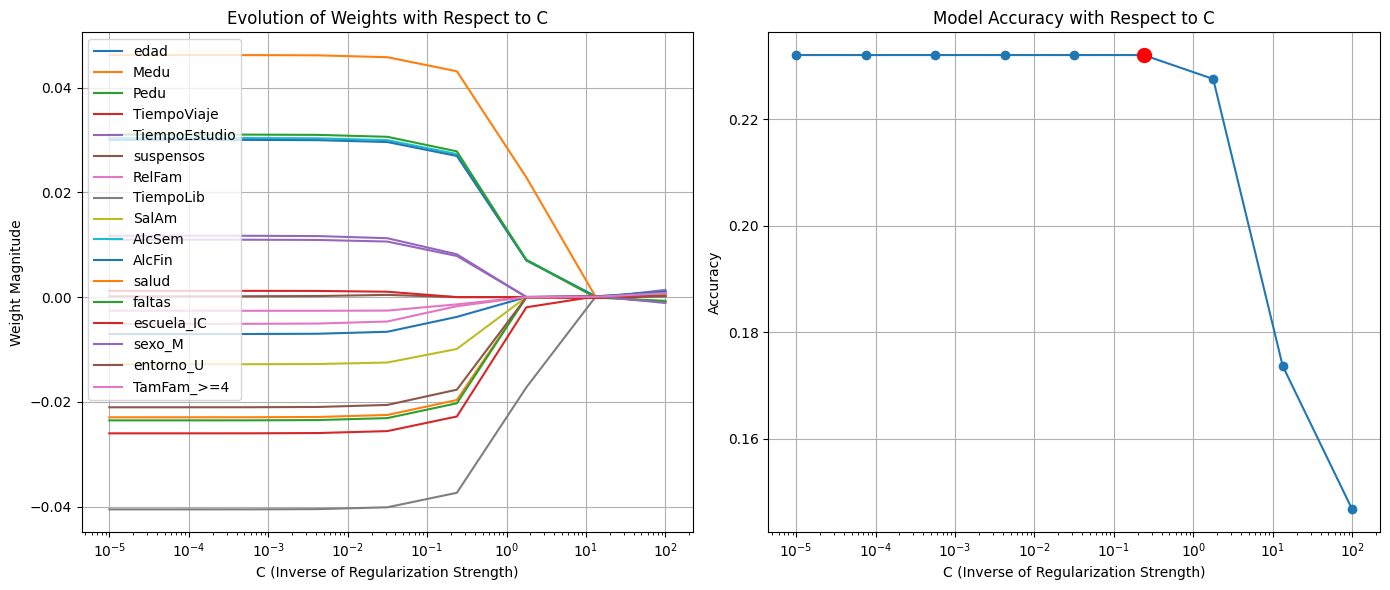

In [6]:
feature_names = list(X_train.columns)  
selected_class = 20


C_values = np.logspace(-5, 2, num=9) 
weights_evolution = []    # To store the final weights for each C
accuracies = []           # To store accuracy for each C
for C in C_values:
    model = LogisticRegressor(learning_rate = 0.01, penalty = 'lasso')  
    model.fit(X_train, y_train_unstd, num_iterations = 1000, C = C)
    weights_evolution.append(model.weights)
    
    y_pred = model.predict(X_train)
    accuracy = accuracy_score(y_train_unstd, y_pred)
    accuracies.append(accuracy)

n_features, n_classes = weights_evolution[0].shape
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
for feature_index in range(n_features):
    weight_trajectory = [W[feature_index, selected_class] for W in weights_evolution]
    plt.plot(C_values, weight_trajectory, label=f'{feature_names[feature_index]}')
plt.xscale('log')
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('Weight Magnitude')
plt.title('Evolution of Weights with Respect to C')
plt.legend(loc='best')
plt.grid(True)

max_accuracy = max(accuracies)
optimum_C_values = [C_values[i] for i in range(9) if accuracies[i] >= max_accuracy ]
optimum_C = max(optimum_C_values)
print(f"The optimum value of C based on accuracy is: {optimum_C}")

plt.subplot(1, 2, 2)
plt.plot(C_values, accuracies, marker='o', linestyle='-')
plt.plot(optimum_C, max_accuracy, 'ro', markersize=10, label='Optimum C')
plt.xscale('log')
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('Accuracy')
plt.title('Model Accuracy with Respect to C')
plt.grid(True)

plt.tight_layout()
plt.show()

In the Model 1, adding reduction of dimensionality boosted Logistic Regression, let's see if we can get the same here.

In [10]:
X = X_train_p.copy()
y = y_train_p.copy()

param_grid = {
    'kpca__kernel': ['rbf', 'poly', 'sigmoid','cosine'],
    'kpca__gamma': [0.01, 0.1, 1],
    'kpca__degree': [2, 3, 4],
    'kpca__eigen_solver': ['auto', 'dense', 'arpack', 'randomized'],
    'kpca__n_components': [20, 30]
}

pipe = Pipeline([
    ('scaler', StandardScaler()),  # This step safely separates train and test and standarizes using only the training data
    ('kpca', KernelPCA(n_components=2, fit_inverse_transform=False)),
    ('model', LogisticRegression())  
])

grid = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy' if y.nunique() < 10 else 'r2')
grid.fit(X, y)

print("Best parameters:", grid.best_params_)
print("Best score:", grid.best_score_)


c:\Users\luciaa_herraiz\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\luciaa_herraiz\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\luciaa_herraiz\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

Best parameters: {'kpca__degree': 2, 'kpca__eigen_solver': 'auto', 'kpca__gamma': 0.01, 'kpca__kernel': 'cosine', 'kpca__n_components': 30}
Best score: 0.09339139170833743


c:\Users\luciaa_herraiz\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
45 fits failed out of a total of 1440.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\luciaa_herraiz\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\luciaa_herraiz\anaconda3\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\luciaa_herraiz\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 654,

#### 2. SVR

This time I will discard SVR, since it has worse performance than other models and it looks like it is very overfitted.

In [4]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'kernel': ['linear', 'rbf', 'poly']
}

svr = SVR()
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='r2', verbose=0, n_jobs=-1)
grid_search.fit(X_train, y_train_unstd)
print("Best parameters found:", grid_search.best_params_)
print("Best score found:", grid_search.best_score_)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)

a,b = cross_validation(best_model,X_train,y_train_unstd,10)
print('Score CV: ',a)
print('std CV: ',b)
print('Internal score: ',best_model.score(X_test,y_test_unstd))
print(evaluate_regression_metrics(y_test_unstd,y_train_unstd,y_pred,y_pred_train))

Best parameters found: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best score found: 0.25035380020230324
Score CV:  0.23637817312091255
std CV:  0.14292483638341635
Internal score:  0.25858382299935556
{'Mean Absolute Error:': 2.64943107631854, 'Mean Squared Error:': 12.842606950825498, 'R² Score Test:': 0.2675751606254758, 'R² Score Train:': 0.7154230892099086}


#### 3. Bagging (Regression)

In [17]:
n_est = [6,10,14,20,30,50,100,200]

for n_estimators in n_est:
    print(n_estimators)
    max_samples = 0.8

    bagging = Bagging_Ensemble(tipo = 'reg') 
    bagging.fit(X_train,X_test, y_train_unstd,n_estimators=n_estimators,max_samples=max_samples)
    bagging_pred = bagging.predict()
    print(f'Score Manual implementation: {bagging.score(y_test_unstd,y_train_unstd)}')

    bagging = BaggingRegressor(random_state=0,n_estimators=n_estimators) 
    bagging.fit(X_train, y_train_unstd)
    bagging_pred = bagging.predict(X_test)
    bagging_pred_train = bagging.predict(X_train)
    score = evaluate_regression_metrics(y_test_unstd,y_train_unstd,bagging_pred,bagging_pred_train)
    print(f'Score Sklearn implementation: {score}')

6
Score Manual implementation: {'Mean Absolute Error:': 2.4550898203592815, 'Mean Squared Error:': 9.674318030605454, 'R² Score Test:': 0.22524004423437582, 'R² Score Train:': 0.7420769284475455}
Score Sklearn implementation: {'Mean Absolute Error:': 2.3792415169660677, 'Mean Squared Error:': 9.087824351297405, 'R² Score Test:': 0.2722089174510739, 'R² Score Train:': 0.8497815605947404}
10
Score Manual implementation: {'Mean Absolute Error:': 2.286826347305389, 'Mean Squared Error:': 7.91634730538922, 'R² Score Test:': 0.3660257117095387, 'R² Score Train:': 0.8160419420113942}
Score Sklearn implementation: {'Mean Absolute Error:': 2.1526946107784433, 'Mean Squared Error:': 7.004011976047905, 'R² Score Test:': 0.43908935063145005, 'R² Score Train:': 0.8652447475897107}
14
Score Manual implementation: {'Mean Absolute Error:': 2.235671514114628, 'Mean Squared Error:': 7.709855798606868, 'R² Score Test:': 0.3825624174653923, 'R² Score Train:': 0.8163536482589835}
Score Sklearn implementati

#### 4. Random Forest (Regression)

In [9]:
max_samples = 0.8
max_features = 0.8

for n_estimators in [6,10,14,20,30,50,100]:
    print(n_estimators)

    rf = Random_Forest_ensemble(tipo = 'reg') 
    rf.fit(X_train,X_test, y_train_unstd,n_estimators=n_estimators,max_samples=max_samples,max_features=max_features)
    rf_pred = rf.predict()
    print(f'Score Manual implementation: {rf.score(y_test_unstd,y_train_unstd)}')


    rf = RandomForestRegressor(random_state=0,n_estimators=n_estimators,max_features=max_features) 
    rf.fit(X_train, y_train_unstd)
    rf_pred = rf.predict(X_test)
    rf_pred_train = rf.predict(X_train)
    print(f'Score Sklearn implementation: {evaluate_regression_metrics(y_test_unstd,y_train_unstd,rf_pred,rf_pred_train)}')

6
Score Manual implementation: {'Mean Absolute Error:': 2.3343313373253487, 'Mean Squared Error:': 8.171490352628078, 'R² Score Test:': 0.34559278658062254, 'R² Score Train:': 0.7877047806075271}
Score Sklearn implementation: {'Mean Absolute Error:': 2.4421157684630734, 'Mean Squared Error:': 9.462242182302065, 'R² Score Test:': 0.24222396747637498, 'R² Score Train:': 0.839204760604137}
10
Score Manual implementation: {'Mean Absolute Error:': 2.265269461077844, 'Mean Squared Error:': 8.071916167664671, 'R² Score Test:': 0.3535671048626544, 'R² Score Train:': 0.7980414182862705}
Score Sklearn implementation: {'Mean Absolute Error:': 2.24311377245509, 'Mean Squared Error:': 7.788862275449102, 'R² Score Test:': 0.3762352474974586, 'R² Score Train:': 0.8575371504094553}
14
Score Manual implementation: {'Mean Absolute Error:': 2.244225834046193, 'Mean Squared Error:': 8.160546254429914, 'R² Score Test:': 0.34646923585684863, 'R² Score Train:': 0.8180037125742116}
Score Sklearn implementatio

### 5. Boosting

Basic Gradient Boosting Implementation (my code and sklearn's)

In [20]:
max_samples = 0.8
max_features = 0.8

for n_estimators in [6, 10, 14, 20, 30, 50, 100]:
    print(n_estimators)

    gb = Boosting_Regressor(n_estimators=n_estimators)
    gb.fit(X_train, y_train_unstd)
    gb_pred = gb.predict(X_test)
    gb_pred_train = gb.predict(X_train)
    print(f'Score Manual implementation: {evaluate_regression_metrics(y_test_unstd, y_train_unstd, gb_pred, gb_pred_train)}')

    gb = GradientBoostingRegressor(n_estimators=n_estimators,max_features=max_features,subsample=max_samples,random_state=0)
    gb.fit(X_train, y_train_unstd)
    gb_pred = gb.predict(X_test)
    gb_pred_train = gb.predict(X_train)
    print(f'Score Sklearn implementation: {evaluate_regression_metrics(y_test_unstd, y_train_unstd, gb_pred, gb_pred_train)}')

6
Score Manual implementation: {'Mean Absolute Error:': 2.4067661259679762, 'Mean Squared Error:': 9.71784167837126, 'R² Score Test:': 0.22175448801107234, 'R² Score Train:': 0.20380131629218057}
Score Sklearn implementation: {'Mean Absolute Error:': 2.4135391463116327, 'Mean Squared Error:': 9.795074444214208, 'R² Score Test:': 0.21556936425776585, 'R² Score Train:': 0.21283356476079418}
10
Score Manual implementation: {'Mean Absolute Error:': 2.381778462664475, 'Mean Squared Error:': 9.214809696015521, 'R² Score Test:': 0.2620393985510907, 'R² Score Train:': 0.2680514274900716}
Score Sklearn implementation: {'Mean Absolute Error:': 2.3640709445661017, 'Mean Squared Error:': 9.032955333184614, 'R² Score Test:': 0.27660305850695865, 'R² Score Train:': 0.2785005758615344}
14
Score Manual implementation: {'Mean Absolute Error:': 2.3272822133762534, 'Mean Squared Error:': 8.618297589806083, 'R² Score Test:': 0.30981058940489814, 'R² Score Train:': 0.3154112025597341}
Score Sklearn impleme

Since Boosting did so good, I investigated some variants of Boosting, and I will try them out here to see if they outperform the previous results

#### 5.2 Categorical Boosting

In theory performes well with datasets with many categorical values, but it got worse results.

In [ ]:
from catboost import CatBoostRegressor

cat = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=3, verbose=0, random_state=0)
cat.fit(X_train, y_train)
cat_pred = cat.predict(X_test)
print(evaluate_regression_metrics(y_test, y_train, cat_pred, cat.predict(X_train)))

{'Mean Absolute Error:': 0.5704774432230822, 'Mean Squared Error:': 0.6379578758971871, 'R² Score Test:': 0.2630265195771633, 'R² Score Train:': 0.5233679316764301}


#### 5.3 XGBoost

It is supposed to do better in general than gradient boosting, but in this case it didn't.

In [5]:
from xgboost import XGBRegressor

for n_estimators in [6, 10, 14, 20, 30, 50, 100]:
    print(n_estimators)
    
    xgb = XGBRegressor(n_estimators=n_estimators, learning_rate=0.1, max_depth=3, random_state=0)
    xgb.fit(X_train, y_train)
    xgb_pred = xgb.predict(X_test)
    print(evaluate_regression_metrics(y_test, y_train, xgb_pred, xgb.predict(X_train)))

6
{'Mean Absolute Error:': 0.6039873469848512, 'Mean Squared Error:': 0.6831474309470411, 'R² Score Test:': 0.0858467871402856, 'R² Score Train:': 0.23167928391969805}
10
{'Mean Absolute Error:': 0.598963166052585, 'Mean Squared Error:': 0.6742336160359295, 'R² Score Test:': 0.09777480175425146, 'R² Score Train:': 0.30121557861104553}
14
{'Mean Absolute Error:': 0.5905261674274991, 'Mean Squared Error:': 0.6640741025132418, 'R² Score Test:': 0.11136974701369806, 'R² Score Train:': 0.34540609740939054}
20
{'Mean Absolute Error:': 0.5690058749487916, 'Mean Squared Error:': 0.6416418319540591, 'R² Score Test:': 0.14138747272626828, 'R² Score Train:': 0.39699335759864685}
30
{'Mean Absolute Error:': 0.5571703434940295, 'Mean Squared Error:': 0.6268713871222165, 'R² Score Test:': 0.16115253219473147, 'R² Score Train:': 0.4650754118952648}
50
{'Mean Absolute Error:': 0.5468209890129067, 'Mean Squared Error:': 0.6015653145186397, 'R² Score Test:': 0.19501583391768584, 'R² Score Train:': 0.549

#### 5.4 Light GBM

Lastly, the last one I will try is Light GBM, it is supposed to work well on large, high-dimensional datasets. It didn't perform better.


In [6]:
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0)
lgbm.fit(X_train, y_train)
lgbm_pred = lgbm.predict(X_test)
print(evaluate_regression_metrics(y_test, y_train, lgbm_pred, lgbm.predict(X_train)))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 158
[LightGBM] [Info] Number of data points in the train set: 668, number of used features: 40
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

#### 6. Stacks (Regression and Classification)

As we can see the stack of regressors is quite good, and the stack of classificators, as expected, performed porrly.

In [13]:
base_models = [
    ('lr', LinearRegression()),
    ('lasso', LassoCV(cv=5)),
    ('RF', RandomForestRegressor(random_state=42)),
    ('svm', SVR(C=1.0, epsilon=0.2)),
]

meta_model = LinearRegression()
stack = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5, passthrough=True)
stack.fit(X_train, y_train_unstd)
y_pred = stack.predict(X_test)
y_pred_train = stack.predict(X_train)
print(evaluate_regression_metrics(y_test_unstd,y_train_unstd, y_pred,y_pred_train))

{'Mean Absolute Error:': 2.1708995799441757, 'Mean Squared Error:': 7.40928797819982, 'R² Score Test:': 0.4066331489119336, 'R² Score Train:': 0.704257009502634}


In [14]:
base_models = [
    ('lr', LogisticRegression(max_iter=1000)), 
    ('svc', SVC(probability=True)),
    ('RF', RandomForestClassifier(random_state=42))
]

meta_model = SVC(probability=True)
stack = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5, passthrough=True)
stack.fit(X_train, y_train_unstd)
y_pred = stack.predict(X_test)
y_pred_train = stack.predict(X_train)
print(evaluate_classification_metrics(y_test_unstd,y_train_unstd,y_pred,y_pred_train))

c:\Users\luciaa_herraiz\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\luciaa_herraiz\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:1380: RuntimeWarning: Number of classes in training fold (17) does not match total number of classes (18). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
c:\Users\luciaa_herraiz\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:1380: RuntimeWarning: Number of classes in training fold (17) does not match total number of classes (18). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
c:\Users\luciaa_herraiz\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWa

{'Accuracy Test': 0.1377245508982036, 'Precision': 0.08425801341856025, 'Recall': 0.1377245508982036, 'F1 Score': 0.10028646344793773, 'Accuracy Train': 0.4491017964071856}


#### 7. Linear Regression (with K-Means Clustering and my personalized class)

In [13]:
LinRegSK = LinearRegression()
LinRegSK.fit(X_train,y_train)

# print(LinRegSK.coef_)

predictions = LinRegSK.predict(X_test)
predictions_train = LinRegSK.predict(X_train)
# print(predictions)

a,b = cross_validation(LinRegSK,X_train,y_train,10)
print('Score CV: ',a)
print('std CV: ',b)
print('Internal score: ',LinRegSK.score(X_test,y_test))
print(evaluate_regression_metrics(y_test,y_train,predictions,predictions_train))

Score CV:  0.18006566079370054
std CV:  0.15556499813572044
Internal score:  0.17748263981028578
{'Mean Absolute Error:': 0.6692486677536744, 'Mean Squared Error:': 0.7999990003305917, 'R² Score Test:': 0.1768342074962309, 'R² Score Train:': 0.30577611224411594}


My personalized class does better than the simple Linear Regressor, however, I had to take away the main relation T1*T2, so the boost is not as obvious as with Model 1.

In [14]:
LR_Rel = LR_Relations()
LR_Rel.fit(X_train,X_test,y_train)
predictions,score = LR_Rel.predict(y_test,y_train)
print(score)

{'Mean Absolute Error:': 0.6638420503886528, 'Mean Squared Error:': 0.789298133725084, 'R² Score Test:': 0.18784495542986568, 'R² Score Train:': 0.3087483612907489}


In [15]:
pca = PCA(n_components=0.95, random_state=42)  # Retain 95% of variance
X_pca = pca.fit_transform(data)

inertia = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

# Choose the optimal number of clusters 
optimal_k =  k_range[np.argmax(inertia)]
print(optimal_k)
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
labels = kmeans.fit_predict(X_pca)

# Evaluate clustering performance
sil_score = silhouette_score(X_pca, labels)
db_score = davies_bouldin_score(X_pca, labels)
print(f'Silhouette Score: {sil_score:.3f}')
print(f'Davies-Bouldin Index: {db_score:.3f}')

df_clusters = data.copy()
df_clusters['cluster'] = labels

scaler = StandardScaler()
df_clusters['cluster'] = scaler.fit_transform(df_clusters[['cluster']])

X_train_c = df_clusters.drop(columns=['T3','T1','T2']).reset_index(drop=True)
y_train_c = df_clusters['T3'].reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(X_train_p,y_train_p,test_size=0.2)

LinRegSK = LinearRegression()
LinRegSK.fit(X_train,y_train)

# print(LinRegSK.coef_)

predictions = LinRegSK.predict(X_test)
predictions_train = LinRegSK.predict(X_train)
# print(predictions)

a,b = cross_validation(LinRegSK,X_train,y_train,10)
print('Score CV: ',a)
print('std CV: ',b)
print('Internal score: ',LinRegSK.score(X_test,y_test))
print(evaluate_regression_metrics(y_test,y_train,predictions,predictions_train))

2
Silhouette Score: 0.932
Davies-Bouldin Index: 0.075
Score CV:  0.21477482046913288
std CV:  0.0904596008609294
Internal score:  0.14270091949712949
{'Mean Absolute Error:': 2.5182176346379923, 'Mean Squared Error:': 11.916934288885873, 'R² Score Test:': 0.1545459207163038, 'R² Score Train:': 0.3095083970732334}


#### 7. Pipelines with reduction of dimensionality

In [4]:
X = X_train_p.copy()
y = y_train_p.copy()

param_grid = {
    'kpca__kernel': ['rbf', 'poly', 'sigmoid','cosine'],
    'kpca__gamma': [0.01, 0.1, 1],
    'kpca__degree': [2, 3, 4],
    'kpca__eigen_solver': ['auto', 'dense', 'arpack', 'randomized'],
    'kpca__n_components': [20, 30,40]
}

pipe = Pipeline([
    ('scaler', StandardScaler()),  # This step safely separates train and test and standarizes using only the training data
    ('kpca', KernelPCA(n_components=2, fit_inverse_transform=False)),
    ('model', LinearRegression())  
])

grid = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy' if y.nunique() < 10 else 'r2')
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best score:", grid.best_score_)

Best parameters: {'kpca__degree': 4, 'kpca__eigen_solver': 'randomized', 'kpca__gamma': 0.1, 'kpca__kernel': 'cosine', 'kpca__n_components': 30}
Best score: 0.22276710192360402


c:\Users\luciaa_herraiz\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
84 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\luciaa_herraiz\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\luciaa_herraiz\anaconda3\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\luciaa_herraiz\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 654,

In [21]:
final_model = Pipeline([
    ('scaler', StandardScaler()),
    ('kpca', KernelPCA(kernel='cosine', gamma=0.01, degree=4, eigen_solver='randomized', n_components=30,fit_inverse_transform=False)),
    ('model', LinearRegression())
])


final_model.fit(X_train, y_train)
print(final_model.score(X_test,y_test))

0.1105713457068016


There was data leakage at first, so the score seemed higher than it was.